### Ensemble Model Example

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import hvplot.pandas
import matplotlib.pyplot as plt
import yfinance as yf
import alpaca_trade_api as alpaca

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.metrics import classification_report
from pandas.tseries.offsets import DateOffset

In [2]:
# Connects to the Alpaca API
alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version = 'v2')

# Set the ticker symbol and time frame
ticker = "AAPL"
timeframe = "1Day"

# Define start and end dates
start_date = "2012-01-01T00:00:00-00:00"
end_date = "2022-01-01T00:00:00-00:00"

# Retrieve the data
data = alpaca_api.get_bars(ticker, timeframe, start_date, end_date).df
df = pd.DataFrame(data)# Convert the data to a Pandas dataframe
df.head()

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2016-01-04 05:00:00+00:00,105.35,105.368,102.00,351452,102.61,71935339,104.007250
2016-01-05 05:00:00+00:00,102.71,105.850,102.41,321365,105.75,58690536,103.414304
2016-01-06 05:00:00+00:00,100.70,102.370,99.87,409164,100.56,71079827,100.847762
2016-01-07 05:00:00+00:00,96.45,100.130,96.43,462836,98.68,85996453,98.046209
2016-01-08 05:00:00+00:00,96.96,99.110,96.76,419555,98.55,75066292,97.916490


In [3]:
# Calculate the midpoint price
df['Mid'] = (df['high'] + df['low']) / 2

# Calculate specific period moving average
df['2MA'] = df['close'].rolling(2).mean() 
df['3MA'] = df['close'].rolling(3).mean()
df['10MA'] = df['close'].rolling(10).mean()

# Calculate the difference between the 3-period and 10-period moving averages
df['Diff'] = df['3MA'] - df['10MA'] 

# Calculate the slope
df['2MASlope'] = df['2MA'].pct_change()
df['3MASlope'] = df['3MA'].pct_change()
df['10MASlope'] = df['10MA'].pct_change()

# Calculate the ratio of the close price to the 3-period moving average
df['CloseDiff3MA'] = df['close'] / df['3MA']

# Calculate the percentage change of the close price
df['close'] = df['close'].pct_change(1)

# Calculate the percentage change of the midpoint price
df['Mid'] = df['Mid'].pct_change(1).shift(-1)

# Drop unnecessary columns
df = df.drop(columns = ['high', 'low', 'volume', 'trade_count'])

# Remove any rows with missing values
df = df.dropna()

# Initialize the 'Signal' column to 0.0    
df["Signal"] = 0.0

# Check if the Mid column value is positive or zero
for index, row in df.iterrows():
    if row["Mid"] >= 0: # If Mid is positive or zero, set Signal column to 1.0
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0: # If Mid is negative, set Signal column to -1.0
       df.loc[index,"Signal"] = -1.0

df.tail(10)

,close,open,vwap,Mid,2MA,3MA,10MA,Diff,2MASlope,3MASlope,10MASlope,CloseDiff3MA,Signal
timestamp,,,,,,,,,,,,,
2021-12-16 05:00:00+00:00,-0.039264,179.280,174.247039,-0.024809,175.780,175.296667,172.906,2.390667,-0.005854,-0.006574,0.004940,0.982677,-1.0
2021-12-17 05:00:00+00:00,-0.006502,169.930,171.183842,-0.014920,171.700,174.233333,173.836,0.397333,-0.023211,-0.006066,0.005379,0.982246,-1.0
2021-12-20 05:00:00+00:00,-0.008122,168.280,169.280615,0.012661,170.445,171.050000,174.279,-3.229000,-0.007309,-0.018271,0.002548,0.992400,1.0
2021-12-21 05:00:00+00:00,0.019087,171.550,171.460750,0.016622,171.370,171.293333,174.460,-3.166667,0.005427,0.001423,0.001039,1.009905,1.0
2021-12-22 05:00:00+00:00,0.015319,173.040,174.303365,0.011810,174.315,172.793333,174.516,-1.722667,0.017185,0.008757,0.000321,1.016474,1.0
2021-12-23 05:00:00+00:00,0.003644,175.850,176.155368,0.015251,175.960,174.970000,174.688,0.282000,0.009437,0.012597,0.000986,1.007487,1.0
2021-12-27 05:00:00+00:00,0.022975,177.085,179.117121,0.006630,178.305,177.416667,174.776,2.640667,0.013327,0.013983,0.000504,1.016421,1.0
2021-12-28 05:00:00+00:00,-0.005767,180.160,179.690104,-0.003029,179.810,178.633333,175.131,3.502333,0.008441,0.006858,0.002031,1.003676,-1.0
2021-12-29 05:00:00+00:00,0.000502,179.330,179.458469,-0.000307,179.335,179.666667,175.636,4.030667,-0.002642,0.005785,0.002884,0.998404,-1.0


In [4]:
columns_list = df.columns # Get a list of column names
dfopt = pd.DataFrame() # Create an empty DataFrame to store selected columns for correlation analysis

for column in columns_list:
    display(df.hvplot.scatter(y = 'Signal', x = column)) # Display a scatter plot of 'Signal' vs the current column
    dfopt = df[['Signal', column]] # Select 'Signal' and the current column
    display(dfopt.corr()) # Display the correlation matrix between 'Signal' and the current column

:Scatter   [close]   (Signal)

,Signal,close
Signal,1.000000,0.177141
close,0.177141,1.000000


:Scatter   [open]   (Signal)

,Signal,open
Signal,1.000000,0.007553
open,0.007553,1.000000


:Scatter   [vwap]   (Signal)

,Signal,vwap
Signal,1.000000,0.015055
vwap,0.015055,1.000000


:Scatter   [Mid]   (Signal)

,Signal,Mid
Signal,1.000000,0.449005
Mid,0.449005,1.000000


:Scatter   [2MA]   (Signal)

,Signal,2MA
Signal,1.000000,0.015486
2MA,0.015486,1.000000


:Scatter   [3MA]   (Signal)

,Signal,3MA
Signal,1.000000,0.012826
3MA,0.012826,1.000000


:Scatter   [10MA]   (Signal)

,Signal,10MA
Signal,1.000000,0.002057
10MA,0.002057,1.000000


:Scatter   [Diff]   (Signal)

,Signal,Diff
Signal,1.000000,0.057079
Diff,0.057079,1.000000


:Scatter   [2MASlope]   (Signal)

,Signal,2MASlope
Signal,1.000000,0.128107
2MASlope,0.128107,1.000000


:Scatter   [3MASlope]   (Signal)

,Signal,3MASlope
Signal,1.000000,0.102028
3MASlope,0.102028,1.000000


:Scatter   [10MASlope]   (Signal)

,Signal,10MASlope
Signal,1.00000,0.05785
10MASlope,0.05785,1.00000


:Scatter   [CloseDiff3MA]   (Signal)

,Signal,CloseDiff3MA
Signal,1.00000,0.13792
CloseDiff3MA,0.13792,1.00000


:Scatter   [Signal]   (Signal)

,Signal,Signal
Signal,1.0,1.0
Signal,1.0,1.0


In [5]:
# Review the value counts
y = df['Signal']
y.value_counts()

Signal
 1.0    858
-1.0    642
Name: count, dtype: int64

In [6]:
X = df[['10MASlope', '2MASlope', 'CloseDiff3MA']] # Select the columns
training_begin = X.index.min() # Determine the beginning of the training period
training_end = X.index.max() - DateOffset(months = 48) # Determine the end of the training period

print(training_begin)
print(training_end)

2016-01-19 05:00:00+00:00
2017-12-30 05:00:00+00:00


In [7]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end + DateOffset(days = 1):]
y_test = y.loc[training_end + DateOffset(days = 1):]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(493, 3)
(493,)
(1007, 3)
(1007,)


In [8]:
# Scale the features DataFrames
scaler = StandardScaler()
X_scaler = scaler.fit(X_train) # Fit the scaler
X_train_scaled = X_scaler.transform(X_train) # Transform the X_train
X_test_scaled = X_scaler.transform(X_test) # Transform the X_test

---
Support Vector Classifier

In [9]:
svm_model = svm.SVC(probability = True)
svm_model = svm_model.fit(X_train_scaled, y_train) # Fit the SVC model
svm_pred = svm_model.predict(X_test_scaled) # Make predictions
svm_testing_report = classification_report(y_test, svm_pred) # Generate a classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.58      0.34      0.43       433
         1.0       0.62      0.81      0.70       574

    accuracy                           0.61      1007
   macro avg       0.60      0.58      0.57      1007
weighted avg       0.60      0.61      0.59      1007



---
Logistic Regression Classifier

In [10]:
logistic_model = LogisticRegression()
logistic_model = logistic_model.fit(X_train_scaled, y_train) # Fit the Logistic Regression model
logistic_pred = logistic_model.predict(X_test_scaled) # Make predictions
logistic_testing_report = classification_report(y_test, logistic_pred) # Generate a classification report
print(logistic_testing_report)

              precision    recall  f1-score   support

        -1.0       0.61      0.45      0.52       433
         1.0       0.65      0.79      0.71       574

    accuracy                           0.64      1007
   macro avg       0.63      0.62      0.62      1007
weighted avg       0.64      0.64      0.63      1007



---
K-Nearest Neighbors Classifier

In [11]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train_scaled, y_train) # Fit the KNN model
knn_pred = knn_model.predict(X_test_scaled) # Make predictions
knn_testing_report = classification_report(y_test, knn_pred) # Generate a classification report
print(knn_testing_report)

              precision    recall  f1-score   support

        -1.0       0.56      0.47      0.51       433
         1.0       0.64      0.72      0.68       574

    accuracy                           0.61      1007
   macro avg       0.60      0.60      0.60      1007
weighted avg       0.61      0.61      0.61      1007



---
Voting Classifier

In [12]:
models = [('svm', svm.SVC(probability = True)),
          ('logistic', LogisticRegression()),
          ('knn', KNeighborsClassifier(n_neighbors = 5))]

voting_model = VotingClassifier(estimators = models, voting = 'hard') # Create a Voting Classifier
voting_model.fit(X_train_scaled, y_train) # Fit the Voting Classifier
voting_pred = voting_model.predict(X_test_scaled) # Make predictions
voting_testing_report = classification_report(y_test, voting_pred) # Generate a classification report
print(knn_testing_report)

              precision    recall  f1-score   support

        -1.0       0.56      0.47      0.51       433
         1.0       0.64      0.72      0.68       574

    accuracy                           0.61      1007
   macro avg       0.60      0.60      0.60      1007
weighted avg       0.61      0.61      0.61      1007



---
Weighted Voting Classifier

In [13]:
models = [('svm', svm.SVC(probability = True)),
          ('logistic', LogisticRegression()),
          ('knn', KNeighborsClassifier(n_neighbors = 5))]

weight_options = np.arange(0.0, 1.2, 0.2)
param_dist = {'weights': [[w1, w2, w3] for w1 in weight_options
                                       for w2 in weight_options 
                                       for w3 in weight_options]}
# Create a Voting Classifier
weighted_voting_model = VotingClassifier(estimators = models, voting = 'hard') 

# Find the best combination of weights
weighted_voting_model_search = RandomizedSearchCV(estimator = weighted_voting_model,
                                                  param_distributions = param_dist,
                                                  scoring = 'accuracy',
                                                  cv = 5,
                                                  n_iter = 100, 
                                                  random_state = 42)

# Fit the Voting Classifier
weighted_voting_model_search.fit(X_train_scaled, y_train)

# Get the best weights and corresponding accuracy score
best_weighted_voting_weights = weighted_voting_model_search.best_params_['weights']
best_weighted_voting_score = weighted_voting_model_search.best_score_

# Make predictions using the best model
best_weighted_voting_model = weighted_voting_model_search.best_estimator_
weighted_voting_pred = best_weighted_voting_model.predict(X_test_scaled)

# Generate a classification report
weighted_voting_testing_report = classification_report(y_test, weighted_voting_pred) 
print(weighted_voting_testing_report)

              precision    recall  f1-score   support

        -1.0       0.61      0.45      0.52       433
         1.0       0.65      0.79      0.71       574

    accuracy                           0.64      1007
   macro avg       0.63      0.62      0.62      1007
weighted avg       0.64      0.64      0.63      1007



---
Stacking Classifier

In [14]:
models = [('svm', svm.SVC(probability = True)),
          ('logistic', LogisticRegression()),
          ('knn', KNeighborsClassifier(n_neighbors = 5))]

# Create a Stacking Classifier
stacking_model = StackingClassifier(estimators = models, 
                                    final_estimator = GaussianNB(), 
                                    cv = 5)

# Fit the Stacking Classifier
stacking_model.fit(X_train_scaled, y_train)

# Make predictions
stacking_pred = stacking_model.predict(X_test_scaled)

# Generate a classification report
stacking_testing_report = classification_report(y_test, stacking_pred) 
print(stacking_testing_report)

              precision    recall  f1-score   support

        -1.0       0.59      0.46      0.52       433
         1.0       0.65      0.76      0.70       574

    accuracy                           0.63      1007
   macro avg       0.62      0.61      0.61      1007
weighted avg       0.63      0.63      0.62      1007



---
Voting Classifier Prediction Visualization

In [15]:
predictions_df = pd.DataFrame(index = X_test.index) # Initialize DataFrame with the index of the test features
predictions_df["predicted_signal"] = voting_pred # Store the predicted signals
predictions_df["actual_returns"] = df["close"].shift(-1) # Shift the 'close' prices
predictions_df["trading_algorithm_returns"] = (predictions_df["actual_returns"] * predictions_df["predicted_signal"]) # Calculate the returns
display(predictions_df['predicted_signal'].value_counts()) # Review the value counts of predicted signal

predicted_signal
 1.0    708
-1.0    299
Name: count, dtype: int64

<Axes: xlabel='timestamp'>

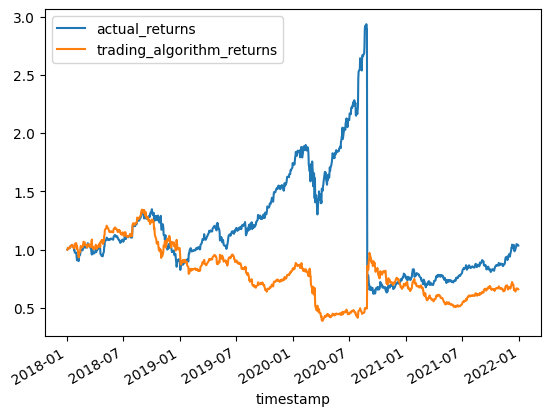

In [16]:
# Plot the cumulative product of actual returns and trading algorithm returns over time
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---
Weighted Voting Classifier Prediction Visualization

In [17]:
predictions_df = pd.DataFrame(index = X_test.index) # Initialize DataFrame with the index of the test features
predictions_df["predicted_signal"] = weighted_voting_pred # Store the predicted signals
predictions_df["actual_returns"] = df["close"].shift(-1) # Shift the 'close' prices
predictions_df["trading_algorithm_returns"] = (predictions_df["actual_returns"] * predictions_df["predicted_signal"]) # Calculate the returns
display(predictions_df['predicted_signal'].value_counts()) # Review the value counts of predicted signal

predicted_signal
 1.0    690
-1.0    317
Name: count, dtype: int64

<Axes: xlabel='timestamp'>

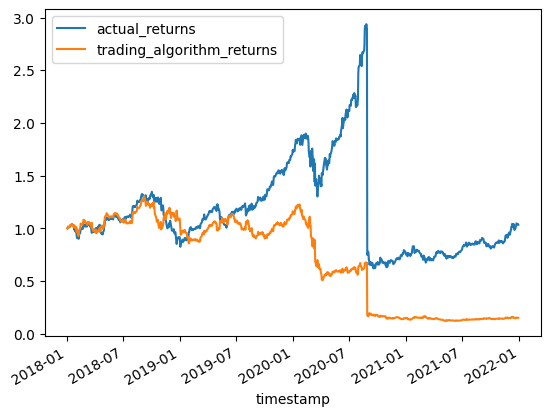

In [18]:
# Plot the cumulative product of actual returns and trading algorithm returns over time
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---
Stacking Classifier Prediction Visualization

In [19]:
predictions_df = pd.DataFrame(index = X_test.index) # Initialize DataFrame with the index of the test features
predictions_df["predicted_signal"] = stacking_pred # Store the predicted signals
predictions_df["actual_returns"] = df["close"].shift(-1) # Shift the 'close' prices
predictions_df["trading_algorithm_returns"] = (predictions_df["actual_returns"] * predictions_df["predicted_signal"]) # Calculate the returns
display(predictions_df['predicted_signal'].value_counts()) # Review the value counts of predicted signal

predicted_signal
 1.0    673
-1.0    334
Name: count, dtype: int64

<Axes: xlabel='timestamp'>

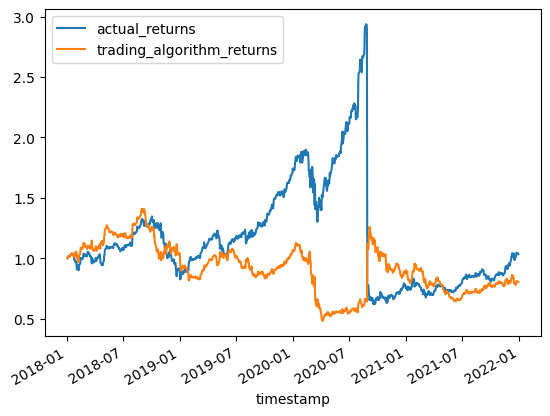

In [20]:
# Plot the cumulative product of actual returns and trading algorithm returns over time
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()